## Sentiment to Strategy: Leveraging Forums Discussions to Guide Automated Trading Decisions 

---

### 0. Importing libraries

In [116]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import praw
import csv
import time
from datetime import datetime, timedelta
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
import string
import yfinance as yf   
from pathlib import Path
import locale

---

### 1. Reddit API Data Extraction and Manipulation

In [117]:
# Initialize PRAW (Python Reddit API Wrapper)
user_agent = "StockMarket Sentiment Analysis"
reddit = praw.Reddit(
    client_id="SDD6BO5WvswKQ2DOZrioiQ",
    client_secret="BoGTdq9xg1Wu4kjy3zj_WBLbTInQvQ",
    user_agent=user_agent
)

# Initialize the subreddit
subreddit = reddit.subreddit("wallstreetbets")

In [118]:
# List to hold data for each post
posts = []

# Fetch posts from the subreddit
for submission in subreddit.new(limit=None):
    post_date = datetime.fromtimestamp(submission.created_utc)
    posts.append({
        'id': submission.id,
        'title': submission.title,
        'selftext': submission.selftext,
        'score': submission.score,
        'upvote_ratio': submission.upvote_ratio,       
        'created_date': post_date,
        'permalink': f"https://redd.it/{submission.id}"
    })

# Convert the list to a DataFrame
raw_df = pd.DataFrame(posts)
raw_df

,id,title,selftext,score,upvote_ratio,created_date,permalink
0,1kvywal,Stocks Rise on Trump’s Tariff Delay; Dollar Wa...,,1,1.00,2025-05-26 18:36:42,https://redd.it/1kvywal
1,1kvys7m,Shiba holder dinner 🔥,,1,0.60,2025-05-26 18:31:57,https://redd.it/1kvys7m
2,1kvyp7w,$XXII CEO wants pregnant women to smoke his ci...,Nobody: ….\n\nAbsolutely no one: ….\n\nNot a s...,17,0.68,2025-05-26 18:28:42,https://redd.it/1kvyp7w
3,1kvyln3,Here s how my gambling went last week. How s y...,,12,0.83,2025-05-26 18:24:40,https://redd.it/1kvyln3
4,1kvwb3d,NVDA Bulls vs. Tariffs: Who Wins on Earnings Day,NVDA reports after close on May 28. Last earni...,44,0.86,2025-05-26 16:51:33,https://redd.it/1kvwb3d
...,...,...,...,...,...,...,...
848,1kdh2gs,"If the Feds start cutting interest rate, won't...","I mean, cutting interest rate means better acc...",494,0.87,2025-05-03 03:11:46,https://redd.it/1kdh2gs
849,1kdf6gx,How it’s possible for QQQX to have a price to ...,Isn’t this mainly a leveraged fund that tracks...,12,0.81,2025-05-03 01:36:24,https://redd.it/1kdf6gx
850,1kdf4is,Dont recommend anyone YOLOing their live savin...,,197,0.91,2025-05-03 01:33:47,https://redd.it/1kdf4is
851,1kddklx,Monday being the 10th consecutive green day ma...,\nmy rationale here might make me sound like a...,1035,0.93,2025-05-03 00:21:09,https://redd.it/1kddklx


In [119]:
# Create a csv file with the data
if os.path.exists('wsb_posts.csv'):
    existing_df = pd.read_csv('wsb_posts.csv')
    combined_df = pd.concat([existing_df, raw_df]).drop_duplicates(subset=['id'])
    combined_df.to_csv('wsb_posts.csv', index=False)
else:
    raw_df.to_csv('wsb_posts.csv', index=False)

In [120]:
# Load the data from the csv file
df = pd.read_csv('wsb_posts.csv')
df

,id,title,selftext,score,upvote_ratio,created_date,permalink,text
0,1kqotlw,Whats your opinion about Rocket Lab?,I see many ppl hyping rocket lab and also boug...,1,1.00,2025-05-20 00:12:16,https://redd.it/1kqotlw,Whats your opinion about Rocket Lab? I see man...
1,1kqoadm,Fed's Powell has sounded the alarm for years a...,NaN,125,0.94,2025-05-19 23:49:38,https://redd.it/1kqoadm,Fed's Powell has sounded the alarm for years a...
2,1kqo5u3,Big beautiful bill,Am I screwed with my sp500 ETFs as a French in...,0,0.25,2025-05-19 23:44:20,https://redd.it/1kqo5u3,Big beautiful bill Am I screwed with my sp500 ...
3,1kqo1xz,Question on UNH Stock,"Should I sell UNH calls, covered calls or hold...",11,0.87,2025-05-19 23:39:50,https://redd.it/1kqo1xz,"Question on UNH Stock Should I sell UNH calls,..."
4,1kqmxov,Is this gonna print tomorrow,"Held these over the weekend, at its peak today...",0,0.44,2025-05-19 22:54:47,https://redd.it/1kqmxov,Is this gonna print tomorrow Held these over t...
...,...,...,...,...,...,...,...,...
1167,1kvubow,Dollar under pressure as tariffs start to stir...,he U.S. dollar is testing a couple of key supp...,139,0.90,2025-05-26 15:26:31,https://redd.it/1kvubow,NaN
1168,1kvyln3,Here s how my gambling went last week. How s y...,NaN,2,0.63,2025-05-26 18:24:40,https://redd.it/1kvyln3,NaN
1169,1kvywal,Stocks Rise on Trump’s Tariff Delay; Dollar Wa...,NaN,1,1.00,2025-05-26 18:36:42,https://redd.it/1kvywal,NaN
1170,1kvys7m,Shiba holder dinner 🔥,NaN,1,0.60,2025-05-26 18:31:57,https://redd.it/1kvys7m,NaN


In [121]:
# Read the S&P 500 companies list from the CSV file
csv_file = 'stocks.csv'
stocks_df = pd.read_csv(csv_file)

# Extract the ticker symbols (the column is usually named "Symbol")
tickers = stocks_df['Symbol'].tolist()

# Extract the names of the companies
companies = stocks_df['Name'].tolist()

In [122]:
# # Combine title and selftext into one column to search both
# raw_df['text'] = raw_df['title'].fillna('') + " " + raw_df['selftext'].fillna('')

# # Filter only the needed columns
# filtered_reddit = raw_df.copy()
# filtered_reddit.drop(columns=['title', 'selftext', 'score', 'upvote_ratio'], axis=1, inplace=True)
# filtered_reddit

In [123]:
# Combine title and selftext into one column to search both
df['text'] = df['title'].fillna('') + " " + df['selftext'].fillna('')

# Filter only the needed columns
filtered_reddit = df.copy()
filtered_reddit.drop(columns=['title', 'selftext', 'score', 'upvote_ratio'], axis=1, inplace=True)
filtered_reddit

,id,created_date,permalink,text
0,1kqotlw,2025-05-20 00:12:16,https://redd.it/1kqotlw,Whats your opinion about Rocket Lab? I see man...
1,1kqoadm,2025-05-19 23:49:38,https://redd.it/1kqoadm,Fed's Powell has sounded the alarm for years a...
2,1kqo5u3,2025-05-19 23:44:20,https://redd.it/1kqo5u3,Big beautiful bill Am I screwed with my sp500 ...
3,1kqo1xz,2025-05-19 23:39:50,https://redd.it/1kqo1xz,"Question on UNH Stock Should I sell UNH calls,..."
4,1kqmxov,2025-05-19 22:54:47,https://redd.it/1kqmxov,Is this gonna print tomorrow Held these over t...
...,...,...,...,...
1167,1kvubow,2025-05-26 15:26:31,https://redd.it/1kvubow,Dollar under pressure as tariffs start to stir...
1168,1kvyln3,2025-05-26 18:24:40,https://redd.it/1kvyln3,Here s how my gambling went last week. How s y...
1169,1kvywal,2025-05-26 18:36:42,https://redd.it/1kvywal,Stocks Rise on Trump’s Tariff Delay; Dollar Wa...
1170,1kvys7m,2025-05-26 18:31:57,https://redd.it/1kvys7m,Shiba holder dinner 🔥


In [124]:
# Create a mapping from cleaned company names (lowercase) to their corresponding ticker
company_mapping = {company.lower(): ticker for company, ticker in zip(companies, tickers)}

# Find matching tickers in the text, replacing company name matches with their stock codes
def matching_tickers(text):
    matched = [str(ticker) for ticker in tickers if str(ticker) in text]
    for company in companies:
        if company.lower() in text.lower():
            ticker_code = company_mapping.get(company.lower())
            if ticker_code:
                matched.append(ticker_code)
    return matched

# Apply the matching function to the 'text' column and remove duplicates
filtered_reddit['tickers'] = filtered_reddit['text'].apply(matching_tickers)
filtered_reddit['tickers'] = filtered_reddit['tickers'].apply(lambda x: list(set(x)))
filtered_reddit

,id,created_date,permalink,text,tickers
0,1kqotlw,2025-05-20 00:12:16,https://redd.it/1kqotlw,Whats your opinion about Rocket Lab? I see man...,"[W, R, L]"
1,1kqoadm,2025-05-19 23:49:38,https://redd.it/1kqoadm,Fed's Powell has sounded the alarm for years a...,[F]
2,1kqo5u3,2025-05-19 23:44:20,https://redd.it/1kqo5u3,Big beautiful bill Am I screwed with my sp500 ...,"[T, S, ET, A, B, F, E]"
3,1kqo1xz,2025-05-19 23:39:50,https://redd.it/1kqo1xz,"Question on UNH Stock Should I sell UNH calls,...","[T, S, UNH, H, U]"
4,1kqmxov,2025-05-19 22:54:47,https://redd.it/1kqmxov,Is this gonna print tomorrow Held these over t...,"[T, R, L, W, O, H]"
...,...,...,...,...,...
1167,1kvubow,2025-05-26 15:26:31,https://redd.it/1kvubow,Dollar under pressure as tariffs start to stir...,"[T, R, S, X, V, C, SD, A, M, EU, F, DX, H, J, ..."
1168,1kvyln3,2025-05-26 18:24:40,https://redd.it/1kvyln3,Here s how my gambling went last week. How s y...,[H]
1169,1kvywal,2025-05-26 18:36:42,https://redd.it/1kvywal,Stocks Rise on Trump’s Tariff Delay; Dollar Wa...,"[T, R, S, W, M, D]"
1170,1kvys7m,2025-05-26 18:31:57,https://redd.it/1kvys7m,Shiba holder dinner 🔥,[S]


In [125]:
# Remove substring tickers
def remove_substring_tickers(tickers):
    # Remove duplicates
    tickers = list(set(tickers))
    # Sort tickers by length in descending order
    tickers.sort(key=len, reverse=True)
    # Create a new list to store the filtered tickers
    filtered_tickers = []
    for ticker in tickers:
        # Check if the ticker is a substring of any other ticker in the list
        if not any(ticker in other_ticker for other_ticker in tickers if ticker != other_ticker):
            filtered_tickers.append(ticker)
    return filtered_tickers

# Apply the function to the filtered_reddit['tickers'] column
filtered_reddit['tickers'] = filtered_reddit['tickers'].apply(remove_substring_tickers)
filtered_reddit

,id,created_date,permalink,text,tickers
0,1kqotlw,2025-05-20 00:12:16,https://redd.it/1kqotlw,Whats your opinion about Rocket Lab? I see man...,"[W, R, L]"
1,1kqoadm,2025-05-19 23:49:38,https://redd.it/1kqoadm,Fed's Powell has sounded the alarm for years a...,[F]
2,1kqo5u3,2025-05-19 23:44:20,https://redd.it/1kqo5u3,Big beautiful bill Am I screwed with my sp500 ...,"[ET, S, A, B, F]"
3,1kqo1xz,2025-05-19 23:39:50,https://redd.it/1kqo1xz,"Question on UNH Stock Should I sell UNH calls,...","[UNH, T, S]"
4,1kqmxov,2025-05-19 22:54:47,https://redd.it/1kqmxov,Is this gonna print tomorrow Held these over t...,"[T, R, L, W, O, H]"
...,...,...,...,...,...
1167,1kvubow,2025-05-26 15:26:31,https://redd.it/1kvubow,Dollar under pressure as tariffs start to stir...,"[EU, DX, SD, T, R, V, C, A, M, F, H, J]"
1168,1kvyln3,2025-05-26 18:24:40,https://redd.it/1kvyln3,Here s how my gambling went last week. How s y...,[H]
1169,1kvywal,2025-05-26 18:36:42,https://redd.it/1kvywal,Stocks Rise on Trump’s Tariff Delay; Dollar Wa...,"[T, R, S, W, M, D]"
1170,1kvys7m,2025-05-26 18:31:57,https://redd.it/1kvys7m,Shiba holder dinner 🔥,[S]


In [126]:
# Remove ambiguous tickers
ambiguous_tickers = (
    list(string.ascii_uppercase)  # single-letter symbols
    + [
        # two-letter everyday words / abbreviations
        "AI", "EV", "IT", "ON", "OR", "NO", "OK", "GO", "SO", "DO", "UP", "EU", "US", "IP", "KO",
        "AM", "PM", "HI", "IN", "AT", "TO", "BY", "MY", "WE", "ME", "HE", "IT", "IS", "AS", "AN",
        # three- to four-letter common words
        "ALL", "FUN", "BIG", "RUN", "NEW", "TOP", "YOU", "CAT", "DOG", "CAR", "SUN", "USA", 
        "IPO", "CAN", "NOW", "AND", "FOR", "OUT", "BUY", "WIN", "LOW", "HIGH", "LOVE", "HATE",
        "EDIT", "TEST", "DATA", "CODE", "TEAM", "WORK", "PLAY", "TIME", "GAME", "NEXT", "BEST",
        "ONE", "TWO", "THREE", "FOUR", "FIVE", "SIX", "SEVEN", "EIGHT", "NINE", "TEN",
        # tech buzz-terms
        "CPU", "GPU", "VR", "AR", "NFT", "ML",
        # meme & slang tickers
        "YOLO", "HODL", "MOON", "LMAO", "LOL", "FOMO", "FUD", "WTF", "BULL", "BEAR",
        # other 
        "Reddit", "WSB", "nan", "NAN"
    ])

# Remove ambiguous tickers from the filtered_reddit['tickers'] column
def remove_ambiguous_tickers(tickers):
    # Remove duplicates
    tickers = list(set(tickers))
    # Filter out ambiguous tickers
    tickers = [ticker for ticker in tickers if ticker not in ambiguous_tickers]
    return tickers

# Apply the function to the filtered_reddit['tickers'] column
filtered_reddit['tickers'] = filtered_reddit['tickers'].apply(remove_ambiguous_tickers)
filtered_reddit

,id,created_date,permalink,text,tickers
0,1kqotlw,2025-05-20 00:12:16,https://redd.it/1kqotlw,Whats your opinion about Rocket Lab? I see man...,[]
1,1kqoadm,2025-05-19 23:49:38,https://redd.it/1kqoadm,Fed's Powell has sounded the alarm for years a...,[]
2,1kqo5u3,2025-05-19 23:44:20,https://redd.it/1kqo5u3,Big beautiful bill Am I screwed with my sp500 ...,[ET]
3,1kqo1xz,2025-05-19 23:39:50,https://redd.it/1kqo1xz,"Question on UNH Stock Should I sell UNH calls,...",[UNH]
4,1kqmxov,2025-05-19 22:54:47,https://redd.it/1kqmxov,Is this gonna print tomorrow Held these over t...,[]
...,...,...,...,...,...
1167,1kvubow,2025-05-26 15:26:31,https://redd.it/1kvubow,Dollar under pressure as tariffs start to stir...,"[DX, SD]"
1168,1kvyln3,2025-05-26 18:24:40,https://redd.it/1kvyln3,Here s how my gambling went last week. How s y...,[]
1169,1kvywal,2025-05-26 18:36:42,https://redd.it/1kvywal,Stocks Rise on Trump’s Tariff Delay; Dollar Wa...,[]
1170,1kvys7m,2025-05-26 18:31:57,https://redd.it/1kvys7m,Shiba holder dinner 🔥,[]


In [127]:
def keep_standalone_tickers(row):
    sentence = row["text"]
    cleaned = []
    for tkr in row["tickers"]:
        # look for the ticker as an independent token, optionally prefixed with $
        # (?<![A-Za-z0-9])  → left boundary is NOT a letter/number
        # (?![A-Za-z0-9])   → right boundary is NOT a letter/number
        pattern = rf'(?<![A-Za-z0-9])\$?{re.escape(tkr)}(?![A-Za-z0-9])'
        if re.search(pattern, sentence):
            cleaned.append(tkr)
    return cleaned

filtered_reddit["tickers"] = filtered_reddit.apply(keep_standalone_tickers, axis=1)
filtered_reddit

,id,created_date,permalink,text,tickers
0,1kqotlw,2025-05-20 00:12:16,https://redd.it/1kqotlw,Whats your opinion about Rocket Lab? I see man...,[]
1,1kqoadm,2025-05-19 23:49:38,https://redd.it/1kqoadm,Fed's Powell has sounded the alarm for years a...,[]
2,1kqo5u3,2025-05-19 23:44:20,https://redd.it/1kqo5u3,Big beautiful bill Am I screwed with my sp500 ...,[]
3,1kqo1xz,2025-05-19 23:39:50,https://redd.it/1kqo1xz,"Question on UNH Stock Should I sell UNH calls,...",[UNH]
4,1kqmxov,2025-05-19 22:54:47,https://redd.it/1kqmxov,Is this gonna print tomorrow Held these over t...,[]
...,...,...,...,...,...
1167,1kvubow,2025-05-26 15:26:31,https://redd.it/1kvubow,Dollar under pressure as tariffs start to stir...,[]
1168,1kvyln3,2025-05-26 18:24:40,https://redd.it/1kvyln3,Here s how my gambling went last week. How s y...,[]
1169,1kvywal,2025-05-26 18:36:42,https://redd.it/1kvywal,Stocks Rise on Trump’s Tariff Delay; Dollar Wa...,[]
1170,1kvys7m,2025-05-26 18:31:57,https://redd.it/1kvys7m,Shiba holder dinner 🔥,[]


In [128]:
# Remove rows with empty 'tickers' list
filtered_reddit = filtered_reddit[filtered_reddit['tickers'].str.len() > 0]
filtered_reddit

,id,created_date,permalink,text,tickers
3,1kqo1xz,2025-05-19 23:39:50,https://redd.it/1kqo1xz,"Question on UNH Stock Should I sell UNH calls,...",[UNH]
6,1kqm5k0,2025-05-19 22:24:03,https://redd.it/1kqm5k0,UNH will make you rich Every week buy $375-$40...,[UNH]
9,1kqlgxj,2025-05-19 21:57:18,https://redd.it/1kqlgxj,hinking About Shorting HIMS I just wanted to ...,[HIMS]
10,1kqju0t,2025-05-19 20:53:40,https://redd.it/1kqju0t,All in on UNH 🚀🚀🚀,[UNH]
11,1kqj0v8,2025-05-19 20:22:26,https://redd.it/1kqj0v8,ROCKING the shorts $TMC TMC is the industry le...,[TMC]
...,...,...,...,...,...
1160,1kv7he1,2025-05-25 19:05:03,https://redd.it/1kv7he1,$UNH CALL$ Is it still gonna print 💰 💵,[UNH]
1163,1kvwb3d,2025-05-26 16:51:33,https://redd.it/1kvwb3d,NVDA Bulls vs. Tariffs: Who Wins on Earnings D...,[NVDA]
1165,1kvvcjj,2025-05-26 16:11:28,https://redd.it/1kvvcjj,$AMC 20k$ call bet for Memorial Weekend pump U...,"[DUOL, AMC]"
1166,1kvuqnj,2025-05-26 15:45:42,https://redd.it/1kvuqnj,NVIDIA Artificial Intelligence Nvidia ([NVDA](...,"[MSFT, AMD, AAPL, VST, INTC, AMZN, GOOGL, NVDA..."


---

### 2. Sentiment Analysis

In [129]:
device = 0 if torch.cuda.is_available() else -1      # -1 ⇒ CPU
model_id = "ProsusAI/finBERT"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if device==0 else torch.float32
)

sent_pipe1 = pipeline(
    task="sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=device,
    return_all_scores=True,    # **preferred** to top_k=None
    truncation=True
)

Device set to use cuda:0
C:\Users\andry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [130]:
LABEL_TO_POLARITY = {"positive": +1, "neutral": 0, "negative": -1}

def finbert_score(text: str) -> float:
    scores = sent_pipe1(text, batch_size=1)[0]           # list[dict]
    # Convert to dict {label: prob}
    scores = {d["label"].lower(): d["score"] for d in scores}

    # Simple +/− difference (prob_pos − prob_neg)
    return scores["positive"] - scores["negative"]

filtered_reddit["sentiment"] = filtered_reddit["text"].apply(finbert_score)
filtered_reddit

C:\Users\andry\AppData\Local\Temp\ipykernel_18292\614457924.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_reddit["sentiment"] = filtered_reddit["text"].apply(finbert_score)


,id,created_date,permalink,text,tickers,sentiment
3,1kqo1xz,2025-05-19 23:39:50,https://redd.it/1kqo1xz,"Question on UNH Stock Should I sell UNH calls,...",[UNH],0.019421
6,1kqm5k0,2025-05-19 22:24:03,https://redd.it/1kqm5k0,UNH will make you rich Every week buy $375-$40...,[UNH],-0.022627
9,1kqlgxj,2025-05-19 21:57:18,https://redd.it/1kqlgxj,hinking About Shorting HIMS I just wanted to ...,[HIMS],-0.884906
10,1kqju0t,2025-05-19 20:53:40,https://redd.it/1kqju0t,All in on UNH 🚀🚀🚀,[UNH],0.041878
11,1kqj0v8,2025-05-19 20:22:26,https://redd.it/1kqj0v8,ROCKING the shorts $TMC TMC is the industry le...,[TMC],0.165686
...,...,...,...,...,...,...
1160,1kv7he1,2025-05-25 19:05:03,https://redd.it/1kv7he1,$UNH CALL$ Is it still gonna print 💰 💵,[UNH],0.010665
1163,1kvwb3d,2025-05-26 16:51:33,https://redd.it/1kvwb3d,NVDA Bulls vs. Tariffs: Who Wins on Earnings D...,[NVDA],0.225862
1165,1kvvcjj,2025-05-26 16:11:28,https://redd.it/1kvvcjj,$AMC 20k$ call bet for Memorial Weekend pump U...,"[DUOL, AMC]",0.038418
1166,1kvuqnj,2025-05-26 15:45:42,https://redd.it/1kvuqnj,NVIDIA Artificial Intelligence Nvidia ([NVDA](...,"[MSFT, AMD, AAPL, VST, INTC, AMZN, GOOGL, NVDA...",0.484017


In [131]:
# # Create a dictionary with dates as keys and tickers with their sentiment scores as values
# def create_sentiment_dict(df):
#     sentiment_dict = {}
#     for i, row in df.iterrows():
#         date = row['created_date'].date()
#         tickers = row['tickers']
#         sentiment = row['sentiment']
        
#         if date not in sentiment_dict:
#             sentiment_dict[date] = {}
        
#         for ticker in tickers:
#             if ticker not in sentiment_dict[date]:
#                 sentiment_dict[date][ticker] = 0
#             sentiment_dict[date][ticker] += sentiment
    
#     return sentiment_dict

# sentiment_dict = create_sentiment_dict(filtered_reddit)
# sentiment_dict

In [132]:
# Create a dictionary with dates as keys and tickers with their sentiment scores as values
def create_sentiment_dict(df):
    sentiment_dict = {}
    for i, row in df.iterrows():
        date = pd.to_datetime(row['created_date']).date()
        tickers = row['tickers']
        sentiment = row['sentiment']
        
        if date not in sentiment_dict:
            sentiment_dict[date] = {}
        
        for ticker in tickers:
            if ticker not in sentiment_dict[date]:
                sentiment_dict[date][ticker] = 0
            sentiment_dict[date][ticker] += sentiment
    
    return sentiment_dict

sentiment_dict = create_sentiment_dict(filtered_reddit)
sentiment_dict

{datetime.date(2025, 5, 19): {'UNH': -0.6481434963643551,
  'HIMS': -0.8849059455096722,
  'TMC': 0.16568553540855646,
  'DD': -0.23903410136699677,
  'TIL': -0.23903410136699677,
  'IOVA': -0.23903410136699677,
  'NVDA': 0.9823753861710429,
  'INOD': -0.732622180134058,
  'AMD': 0.18241581413894892,
  'SMCI': 0.18241581413894892,
  'FIS': 0.18241581413894892,
  'NYC': 0.18241581413894892,
  'HPE': 0.18241581413894892,
  'NVAX': 0.1794784478843212},
 datetime.date(2025, 5, 18): {'UNH': 0.4316422510892153,
  'FCF': 0.033686259761452675,
  'ARE': 0.033686259761452675,
  'OKLO': 0.033686259761452675,
  'MCO': 0.033686259761452675,
  'PT': 0.033686259761452675,
  'ET': 0.9143573809415102,
  'NVDA': 0.9143573809415102,
  'AMD': 0.9143573809415102,
  'INTU': -0.022418949753046036,
  'TOL': -0.022418949753046036,
  'TGT': -0.022418949753046036,
  'BAH': -0.022418949753046036,
  'BIDU': -0.022418949753046036,
  'ROST': -0.022418949753046036,
  'KEYS': -0.022418949753046036,
  'MDT': -0.0224189

In [133]:
# Convert sentiment_dict into a DataFrame and fill missing values with 0
sentiment_df = pd.DataFrame.from_dict(sentiment_dict, orient='index').fillna(0)

# Ensure the index is sorted (dates in ascending order)
sentiment_df.sort_index(inplace=True)
sentiment_df

,UNH,HIMS,TMC,DD,TIL,IOVA,NVDA,INOD,AMD,SMCI,...,HIVE,ADX,SMA,ROCK,LUMN,CMC,VVX,TV,VST,XXII
2025-04-29,0.000000,0.226868,0.000000,-0.592656,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2025-04-30,0.000000,0.000000,0.000000,-0.258047,0.000000,0.000000,-0.884604,0.000000,0.000000,0.267805,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2025-05-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.548674,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2025-05-02,0.000000,0.002060,0.000000,0.538456,0.000000,0.000000,0.241802,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2025-05-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2025-05-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073465,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2025-05-05,0.000000,0.896298,0.000000,0.000000,0.000000,0.000000,0.023025,0.000000,0.594778,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2025-05-06,0.000000,0.000000,0.000000,-0.074986,0.000000,0.000000,-1.205385,0.000000,-0.931695,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2025-05-07,0.000000,-0.033849,0.000000,-0.007439,0.000000,0.000000,0.400313,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2025-05-08,0.000000,1.149612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


---

### 3. Stock Market Comparison

In [134]:
# Create a comparison DataFrame with the same structure as sentiment_df
comparison_df = sentiment_df.copy()
comparison_df

,UNH,HIMS,TMC,DD,TIL,IOVA,NVDA,INOD,AMD,SMCI,...,HIVE,ADX,SMA,ROCK,LUMN,CMC,VVX,TV,VST,XXII
2025-04-29,0.000000,0.226868,0.000000,-0.592656,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2025-04-30,0.000000,0.000000,0.000000,-0.258047,0.000000,0.000000,-0.884604,0.000000,0.000000,0.267805,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2025-05-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.548674,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2025-05-02,0.000000,0.002060,0.000000,0.538456,0.000000,0.000000,0.241802,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2025-05-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2025-05-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073465,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2025-05-05,0.000000,0.896298,0.000000,0.000000,0.000000,0.000000,0.023025,0.000000,0.594778,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2025-05-06,0.000000,0.000000,0.000000,-0.074986,0.000000,0.000000,-1.205385,0.000000,-0.931695,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2025-05-07,0.000000,-0.033849,0.000000,-0.007439,0.000000,0.000000,0.400313,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2025-05-08,0.000000,1.149612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


In [135]:
# Create a dataframe with the same index comparison_df but with a column that contains the number of non-zero entries in each row and another with a list of tickers that have a non-zero sentiment score
def count_non_zero_entries(df):
    non_zero_count = df.ne(0).sum(axis=1)
    non_zero_tickers = df.apply(lambda row: list(row[row != 0].index), axis=1)
    
    return pd.DataFrame({
        'non_zero_count': non_zero_count,
        'non_zero_tickers': non_zero_tickers
    })

non_zero_info = count_non_zero_entries(comparison_df)
non_zero_info

,non_zero_count,non_zero_tickers
2025-04-29,11,"[HIMS, DD, TSLA, HOOD, UPS, GM, WOLF, FUTU, NV..."
2025-04-30,33,"[DD, NVDA, SMCI, TSLA, GOOGL, PLTR, BABA, MSTR..."
2025-05-01,27,"[NVDA, HOOD, CVNA, BABA, MSTR, MSFT, CEP, AAPL..."
2025-05-02,19,"[HIMS, DD, NVDA, TSLA, PLTR, NFLX, MSTR, MSFT,..."
2025-05-03,6,"[TSLA, RKLB, PLTR, CC, QQQX, PB]"
2025-05-04,2,"[AMD, AMC]"
2025-05-05,18,"[HIMS, NVDA, AMD, PT, TSLA, RKLB, PLTR, MSTR, ..."
2025-05-06,22,"[DD, NVDA, AMD, HD, PLTR, COIN, MSFT, PC, RDDT..."
2025-05-07,24,"[HIMS, DD, NVDA, ARE, OKLO, TSLA, RKLB, GOOGL,..."
2025-05-08,28,"[HIMS, ARE, TSLA, PLTR, CVNA, NFLX, MSTR, LLY,..."


In [136]:
# Setting up trading parameters
TOP_N = 10  # long TOP_N, short BOTTOM_N
START_CAPITAL  = 100_000
TX_COST  = 0.0
RISK_FREE_RATE   = 0.02 

In [137]:
# Create a weights DataFrame initialized with zeros
signals = comparison_df.copy() 
weights = pd.DataFrame(0.0, index=signals.index, columns=signals.columns)

# Fill the weights DataFrame with long and short positions based on the signals
for date, row in signals.iterrows():
    # keep only valid positives for longs and negatives for shorts
    pos_scores = row[row > 0]
    neg_scores = row[row < 0]

    long_tickers  = pos_scores.nlargest(TOP_N).index
    short_tickers = neg_scores.nsmallest(TOP_N).index   # most negative

    n_long, n_short = len(long_tickers), len(short_tickers)

    # allocate 50 % of capital to each side (if it exists)
    if n_long:
        long_weight = 0.5 / n_long
        weights.loc[date, long_tickers] =  long_weight
    if n_short:
        short_weight = 0.5 / n_short
        weights.loc[date, short_tickers] = -short_weight
weights

,UNH,HIMS,TMC,DD,TIL,IOVA,NVDA,INOD,AMD,SMCI,...,HIVE,ADX,SMA,ROCK,LUMN,CMC,VVX,TV,VST,XXII
2025-04-29,0.000000,0.083333,0.000000,-0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,...,0.00,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.00,0.000
2025-04-30,0.000000,0.000000,0.000000,-0.050000,0.000000,0.000000,-0.050000,0.000000,0.000000,0.0500,...,0.00,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.00,0.000
2025-05-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.0000,...,0.00,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.00,0.000
2025-05-02,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.050000,0.000000,0.000000,0.0000,...,0.00,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.00,0.000
2025-05-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,...,0.00,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.00,0.000
2025-05-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.0000,...,0.00,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.00,0.000
2025-05-05,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.050000,0.0000,...,0.00,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.00,0.000
2025-05-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.050000,0.000000,-0.050000,0.0000,...,0.00,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.00,0.000
2025-05-07,0.000000,-0.050000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.0000,...,0.00,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.00,0.000
2025-05-08,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,...,0.00,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.00,0.000


In [138]:
def count_weights(df):
    positive_count = df.apply(lambda row: (row > 0).sum(), axis=1)
    negative_count = df.apply(lambda row: (row < 0).sum(), axis=1)
    positive_tickers = df.apply(lambda row: list(row[row > 0].index), axis=1)
    negative_tickers = df.apply(lambda row: list(row[row < 0].index), axis=1)
    
    return pd.DataFrame({
        'positive_count': positive_count,
        'negative_count': negative_count,
        'positive_tickers': positive_tickers,
        'negative_tickers': negative_tickers
    })

weights_info = count_weights(weights)
weights_info

,positive_count,negative_count,positive_tickers,negative_tickers
2025-04-29,6,5,"[HIMS, TSLA, HOOD, FUTU, NVO, HSBC]","[DD, UPS, GM, WOLF, AAL]"
2025-04-30,10,10,"[SMCI, BABA, MSTR, UK, AMZN, UBER, DTE, SBUX, ...","[DD, NVDA, TSLA, PLTR, AAPL, IBM, GOOG, META, ..."
2025-05-01,10,10,"[NVDA, HOOD, MSFT, AAPL, RDDT, META, ANET, TY,...","[CVNA, MSTR, CEP, GOOG, AMZN, JD, MARA, SNAP, ..."
2025-05-02,10,5,"[DD, NVDA, PLTR, NFLX, MSTR, MSFT, RDDT, JD, T...","[TSLA, AAPL, META, AMZN, NKE]"
2025-05-03,3,3,"[RKLB, QQQX, PB]","[TSLA, PLTR, CC]"
2025-05-04,1,1,[AMD],[AMC]
2025-05-05,10,5,"[HIMS, NVDA, AMD, PT, TSLA, PLTR, DE, RCL, NET...","[RKLB, AMZN, UPS, PDD, SOFI]"
2025-05-06,3,10,"[PLTR, UK, AVGO]","[NVDA, AMD, HD, MSFT, PC, SONY, INTC, EA, ADBE..."
2025-05-07,8,10,"[NVDA, ARE, RKLB, LLY, HALO, CVS, NVMI, TRUE]","[HIMS, OKLO, PLTR, MSFT, JPM, ARM, COO, PBI, N..."
2025-05-08,10,5,"[HIMS, TSLA, CVNA, AAPL, UK, AXON, RTO, CTO, R...","[MSTR, LLY, META, ETOR, NYT]"


In [139]:

dates        = weights.index
all_tickers  = weights.columns               # for consistent column order
rows         = []                            # 1 Series per date

for d in dates:
    # --------------------------------------------------------
    # 1) which symbols are actually traded today?
    # --------------------------------------------------------
    todays_pos = weights.loc[d]
    tickers_today = todays_pos[todays_pos != 0].index.tolist()

    # --------------------------------------------------------
    # 2) fetch today’s Close for *only those* symbols
    # --------------------------------------------------------
    if tickers_today:                        # at least one position open
        start = d.strftime('%Y-%m-%d')
        end   = (d + timedelta(days=1)).strftime('%Y-%m-%d')

        df = yf.download(
                tickers_today,
                start=start, end=end,
                progress=False, auto_adjust=True,
                threads=False, group_by="ticker"
             )

        if df.empty:                         # network hiccup / holiday?
            close = pd.Series(np.nan, index=all_tickers, name=d)
        else:
            close = (
                df.xs('Close', level=1, axis=1)  # peel off OHLC level
                  .iloc[0]                       # single row
                  .reindex(all_tickers)          # pad others with NaN
            )
            close.name = d
    else:
        # no positions today → row of NaNs (keeps calendar intact)
        close = pd.Series(np.nan, index=all_tickers, name=d)

    rows.append(close)

# ── assemble full price panel & returns ──────────────────────
prices  = pd.DataFrame(rows)                  # rows = dates, cols = tickers
prices  = prices.ffill()                      # carry prices through flat days
prices  = prices.dropna(axis=1, how='all')    # drop symbols with no data ever

returns = prices.pct_change(fill_method=None).fillna(0)

# align weights / signals to surviving tickers
weights = weights.reindex(columns=prices.columns)
signals = signals.reindex(columns=prices.columns)



6 Failed downloads:
['CC', 'RKLB', 'QQQX', 'PLTR', 'PB', 'TSLA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-05-03 -> 2025-05-04)')

2 Failed downloads:
['AMC', 'AMD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-05-04 -> 2025-05-05)')

1 Failed download:
['ETOR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-05-08 -> 2025-05-09) (Yahoo error = "Data doesn\'t exist for startDate = 1746676800, endDate = 1746763200")')

1 Failed download:
['CORZZ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-05-09 -> 2025-05-10)')

15 Failed downloads:
['GLP', 'RH', 'MSTR', 'EOD', 'POST', 'GOOG', 'HIMS', 'PLTR', 'WMT', 'UNH', 'MELI', 'ES', 'QBTS', 'DD', 'UK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-05-10 -> 2025-05-11)')

14 Failed downloads:
['AMAT', 'SONY', 'CSCO', 'MSTR', 'OKLO', 'HOOD', 'FT', 'NVDA', 'UNH', 'GDDY', 'CRWV', 'BABA', 'WMT', 'CAVA']: YFPricesMissin

In [140]:
prices

,UNH,HIMS,TMC,DD,TIL,IOVA,NVDA,INOD,AMD,SMCI,FIS,NYC,HPE,NVAX,ARE,OKLO,PT,ET,HD,TSLA,RKLB,LUNR,HOOD,GOOGL,RIVN,PLTR,CVNA,ACHR,COIN,CRWV,IBKR,NFLX,BYD,BABA,NBIS,ARR,CCL,MSTR,DKS,LQDA,RAIN,MSFT,LLY,MD,PC,CEP,KDLY,HTZ,AAPL,TMUS,...,AVGO,SNAP,ADBE,PSA,AMC,PDD,RCL,NET,SU,SOFI,CC,TSM,AIP,RBLX,ANET,WBS,TY,DUOL,UUUU,GM,UBER,DTE,SBUX,ADP,TEM,LH,WOLF,FUTU,NVO,HSBC,AAL,LCID,RTX,UTHR,PEG,RSI,GOOS,BMO,AC,RCI,WRD,AES,PFE,INFA,WULF,IONQ,HIVE,ADX,SMA,ROCK
2025-04-29,NaN,35.040001,NaN,65.849998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,292.029999,NaN,NaN,49.369999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.939999,NaN,NaN,NaN,NaN,NaN,NaN,3.47,92.07,65.160004,56.963123,9.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-04-30,NaN,35.040001,NaN,65.989998,NaN,NaN,108.919998,NaN,NaN,31.860001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,282.160004,NaN,NaN,49.369999,NaN,NaN,118.440002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119.430000,NaN,NaN,NaN,380.109985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,212.221710,NaN,...,NaN,7.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.939999,81.010002,137.0,79.490402,300.600006,51.669998,241.009995,3.47,92.07,65.160004,56.963123,9.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-01,NaN,35.040001,NaN,65.989998,NaN,NaN,111.610001,NaN,NaN,31.860001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,282.160004,NaN,NaN,46.619999,NaN,NaN,118.440002,251.869995,NaN,NaN,NaN,NaN,NaN,NaN,119.430000,NaN,NaN,NaN,381.600006,NaN,NaN,NaN,424.620453,NaN,NaN,NaN,50.000000,NaN,NaN,213.040634,NaN,...,NaN,7.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.839996,47.42606,30.02,400.000000,4.55,45.049999,81.010002,137.0,79.490402,300.600006,51.669998,241.009995,3.47,92.07,65.160004,56.963123,9.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-02,NaN,35.040001,NaN,67.250000,NaN,NaN,114.500000,NaN,NaN,31.860001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,287.209991,NaN,NaN,46.619999,NaN,NaN,124.279999,251.869995,NaN,NaN,NaN,NaN,1156.489990,NaN,119.430000,NaN,NaN,NaN,394.369995,NaN,NaN,NaN,434.482361,NaN,NaN,NaN,50.000000,NaN,NaN,205.081070,NaN,...,NaN,7.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,179.279999,6.72,NaN,87.839996,47.42606,30.02,400.000000,4.55,45.049999,81.010002,137.0,79.490402,300.600006,51.669998,241.009995,3.47,92.07,65.160004,56.963123,9.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-03,NaN,35.040001,NaN,67.250000,NaN,NaN,114.500000,NaN,NaN,31.860001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,287.209991,NaN,NaN,46.619999,NaN,NaN,124.279999,251.869995,NaN,NaN,NaN,NaN,1156.489990,NaN,119.430000,NaN,NaN,NaN,394.369995,NaN,NaN,NaN,434.482361,NaN,NaN,NaN,50.000000,NaN,NaN,205.081070,NaN,...,NaN,7.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,179.279999,6.72,NaN,87.839996,47.42606,30.02,400.000000,4.55,45.049999,81.010002,137.0,79.490402,300.600006,51.669998,241.009995,3.47,92.07,65.160004,56.963123,9.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-04,NaN,35.040001,NaN,67.250000,NaN,NaN,114.500000,NaN,NaN,31.860001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,287.209991,NaN,NaN,46.619999,NaN,NaN,124.279999,251.869995,NaN,NaN,NaN,NaN,1156.489990,NaN,119.430000,NaN,NaN,NaN,394.369995,NaN,NaN,NaN,434.482361,NaN,NaN,NaN,50.000000,NaN,NaN,205.081070,NaN,...,NaN,7.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,179.279999,6.72,NaN,87.839996,47.42606,30.02,400.000000,4.55,45.049999,81.010002,137.0,79.490402,300.600006,51.669998,241.009995,3.47,92.07,65.160004,56.963123,9.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-05,NaN,41.880001,NaN,67.250000,NaN,NaN,113.820000,NaN,100.589996,31.860001,NaN,NaN,NaN,NaN,NaN,NaN,0.95,NaN,NaN,280.260010,22.480000,NaN,46.619999,NaN,NaN,123.769997,251.869995,NaN,NaN,NaN,N

In [141]:
returns

,UNH,HIMS,TMC,DD,TIL,IOVA,NVDA,INOD,AMD,SMCI,...,WRD,AES,PFE,INFA,WULF,IONQ,HIVE,ADX,SMA,ROCK
2025-04-29,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-04-30,0.000000,0.000000,0.000000,0.002126,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-01,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.024697,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-02,0.000000,0.000000,0.000000,0.019094,0.0,0.0,0.025894,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-03,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-04,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-05,0.000000,0.195205,0.000000,0.000000,0.0,0.0,-0.005939,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-06,0.000000,0.000000,0.000000,0.000000,0.0,0.0,-0.002460,0.000000,-0.019584,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-07,0.000000,0.250000,0.000000,0.000000,0.0,0.0,0.031002,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-08,0.000000,-0.018147,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [142]:
# yesterday’s weights × today’s returns
gross_ret = (weights.shift() * returns).sum(axis=1)

# simple proportional cost: |Δweights| × TX_COST
turnover  = (weights - weights.shift()).abs().sum(axis=1) * 0.5   # 0.5 buys + 0.5 sells
cost      = turnover * TX_COST

strategy_ret = gross_ret - cost            # net of fees
strategy_ret

2025-04-29    0.000000
2025-04-30   -0.003029
2025-05-01   -0.001552
2025-05-02   -0.003413
2025-05-03    0.000000
2025-05-04    0.000000
2025-05-05    0.000000
2025-05-06   -0.007125
2025-05-07    0.000926
2025-05-08   -0.001126
2025-05-09    0.002462
2025-05-10    0.000000
2025-05-11    0.000000
2025-05-12    0.000000
2025-05-13   -0.002738
2025-05-14    0.000628
2025-05-15   -0.008924
2025-05-16    0.003588
2025-05-17    0.000000
2025-05-18    0.000000
2025-05-19    0.004748
2025-05-20    0.000859
2025-05-21   -0.005048
2025-05-22   -0.001441
2025-05-23    0.003322
2025-05-24    0.000000
2025-05-25    0.000000
2025-05-26    0.000000
dtype: float64

In [143]:
strategy_eq = START_CAPITAL * (1 + strategy_ret).cumprod()
strategy_eq

2025-04-29    100000.000000
2025-04-30     99697.090644
2025-05-01     99542.316398
2025-05-02     99202.569986
2025-05-03     99202.569986
2025-05-04     99202.569986
2025-05-05     99202.569986
2025-05-06     98495.703298
2025-05-07     98586.863337
2025-05-08     98475.850575
2025-05-09     98718.268214
2025-05-10     98718.268214
2025-05-11     98718.268214
2025-05-12     98718.268214
2025-05-13     98447.995471
2025-05-14     98509.849213
2025-05-15     97630.792970
2025-05-16     97981.075426
2025-05-17     97981.075426
2025-05-18     97981.075426
2025-05-19     98446.283994
2025-05-20     98530.898403
2025-05-21     98033.537417
2025-05-22     97892.251458
2025-05-23     98217.468597
2025-05-24     98217.468597
2025-05-25     98217.468597
2025-05-26     98217.468597
dtype: float64

In [144]:
# Benchmarks: S&P 500 and MSCI EAFE
bench_syms = {
    "S&P 500": "^GSPC",
    "Nasdaq": "^IXIC",
    "MSCI World": "URTH",      # iShares MSCI World ETF
    "MSCI EAFE": "EFA"          # iShares MSCI EAFE ETF
}

bench_px = (yf.download(list(bench_syms.values()),
                        start=strategy_eq.index.min().strftime('%Y-%m-%d'),
                        end  =(strategy_eq.index.max()+pd.Timedelta(days=1)).strftime('%Y-%m-%d'),
                        progress=False, auto_adjust=True, threads=False)
              ['Close']              # pull just Close
              .reindex(strategy_eq.index)
              .ffill())

bench_px.columns = bench_syms.keys()
bench_ret        = bench_px.pct_change(fill_method=None).fillna(0)
bench_eq         = (1 + bench_ret).cumprod() * START_CAPITAL

In [145]:
def cagr(curve):
    yrs = len(curve)/252
    return (curve.iloc[-1]/curve.iloc[0])**(1/yrs) - 1

def sharpe(r):
    return np.sqrt(252) * r.sub(RISK_FREE_RATE/252).mean() / r.std() if r.std()!=0 else np.nan

def max_dd(curve):
    return (curve/curve.cummax() - 1).min()

summary = pd.DataFrame({
    "Final $":   [strategy_eq.iloc[-1], *bench_eq.iloc[-1]],
    "CAGR %":    [cagr(strategy_eq), *[cagr(bench_eq[c]) for c in bench_eq]],
    "Sharpe":    [sharpe(strategy_ret), *[sharpe(bench_ret[c]) for c in bench_ret]],
    "Max DD %":  [max_dd(strategy_eq), *[max_dd(bench_eq[c]) for c in bench_eq]]
}, index=["Strategy", *bench_eq.columns]).round(3)

print(summary)

               Final $  CAGR %  Sharpe  Max DD %
Strategy     98217.469  -0.149  -3.876    -0.024
S&P 500     103759.579   0.394   3.882    -0.008
Nasdaq      104397.467   0.473   3.586    -0.018
MSCI World  104351.684   0.467   2.834    -0.027
MSCI EAFE   107306.954   0.886   3.713    -0.025


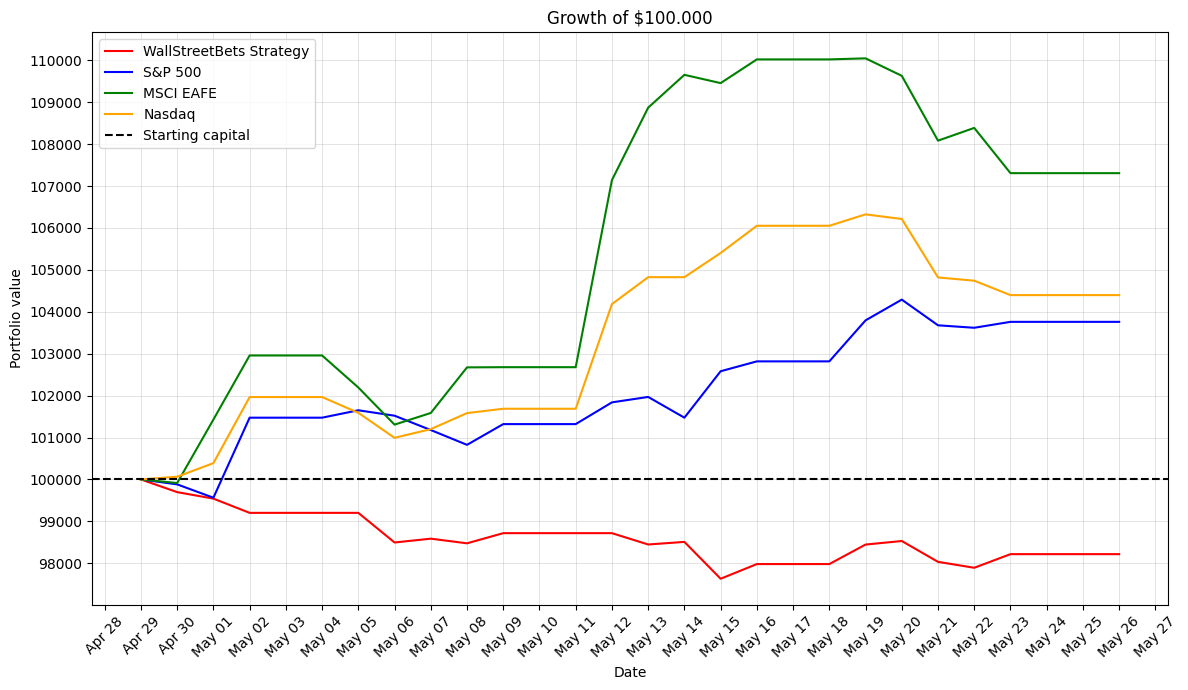

In [149]:
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

# Equity curves plot
plt.figure(figsize=(12,7))
ax = plt.gca()
strategy_eq.plot(label="WallStreetBets Strategy", color='red', ax=ax)
bench_eq['S&P 500'].plot(label="S&P 500", color='blue', ax=ax)
# bench_eq['MSCI World'].plot(label="MSCI World", color='purple', ax=ax)
bench_eq['MSCI EAFE'].plot(label="MSCI EAFE", color='green', ax=ax)
bench_eq['Nasdaq'].plot(label="Nasdaq", color='orange', ax=ax)
start_capital = 100_000 
ax.axhline(y=start_capital, color='black', linewidth=1.5, linestyle='--', label='Starting capital')
plt.title("Growth of $100.000")
plt.ylabel("Portfolio value")
plt.grid(True, linestyle='-', linewidth=0.5, alpha=0.5)

# Set y-axis ticks spaced every 1000 units
ax.yaxis.set_major_locator(ticker.MultipleLocator(1000))

# Use a DayLocator to include all dates and a DateFormatter for English short date names
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

In [147]:
# make a df with the dates as index and value in each day of s&p500 and nasdaq and wsb strategy
def create_equity_curve_df(strategy_eq, bench_eq):
    equity_curve_df = pd.DataFrame({
        'WallStreetBets Strategy': strategy_eq,
        'S&P 500': bench_eq['S&P 500'],
        'Nasdaq': bench_eq['Nasdaq']
    })
    equity_curve_df.index.name = 'Date'
    return equity_curve_df

equity_curve_df = create_equity_curve_df(strategy_eq, bench_eq)
equity_curve_df

,WallStreetBets Strategy,S&P 500,Nasdaq
Date,,,
2025-04-29,100000.000000,100000.000000,100000.000000
2025-04-30,99697.090644,99882.146758,100064.863217
2025-05-01,99542.316398,99563.942105,100389.159510
2025-05-02,99202.569986,101473.188005,101965.244637
2025-05-03,99202.569986,101473.188005,101965.244637
2025-05-04,99202.569986,101473.188005,101965.244637
2025-05-05,99202.569986,101649.972364,101589.059751
2025-05-06,98495.703298,101520.331100,100992.355760
2025-05-07,98586.863337,101178.550404,101199.900241


---

### 4. Visualization 